In [13]:
# Celda 1: Instalación de dependencias
!pip install tensorflow numpy pandas scikit-learn nltk joblib seaborn

In [14]:
# Celda 2: Importar librerías y configurar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Celda 2: Importaciones
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import joblib
import re
from tensorflow.keras.utils import to_categorical

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [16]:
class LSTMSentimentClassifier:
    """
    Clase para entrenar y evaluar un modelo LSTM bidireccional para clasificación de sentimiento.
    """

    def __init__(self, max_words=10000, max_len=200, embedding_dim=100):
        """
        Inicializa el clasificador LSTM.

        Args:
            max_words (int): Número máximo de palabras en el vocabulario
            max_len (int): Longitud máxima de las secuencias
            embedding_dim (int): Dimensión del embedding
        """
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer(num_words=max_words)
        self.model = None

    def prepare_data(self, data_file: str):
        """
        Prepara los datos crudos para el entrenamiento del LSTM.

        Args:
            data_file (str): Ruta al archivo de datos consolidados

        Returns:
            tuple: X_train, X_test, y_train, y_test, class_weights
        """
        logger.info("Cargando y preparando datos para LSTM...")

        # Cargar datos
        df = pd.read_csv(data_file)

        # Verificar y reportar valores nulos
        null_counts = df[['reviews.text', 'reviews.rating']].isnull().sum()
        logger.info(f"Valores nulos antes de limpieza:\n{null_counts}")

        # Limpiar valores nulos
        df['reviews.text'] = df['reviews.text'].fillna('')
        df = df.dropna(subset=['reviews.rating'])

        # Convertir ratings a sentimientos
        df['sentiment'] = df['reviews.rating'].apply(self._convert_rating_to_sentiment)

        # Preprocesar textos para LSTM
        df['processed_text'] = df['reviews.text'].apply(self._preprocess_text_for_lstm)

        # Verificar datos después de limpieza
        logger.info(f"Registros después de limpieza: {len(df)}")

        # Tokenizar textos
        self.tokenizer.fit_on_texts(df['processed_text'])
        sequences = self.tokenizer.texts_to_sequences(df['processed_text'])

        # Padding con longitud máxima adaptativa
        max_length = min(self.max_len, max(len(s) for s in sequences))
        X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

        # Preparar etiquetas (usando to_categorical para mayor robustez)
        sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        y = pd.get_dummies(df['sentiment'].map(sentiment_map)).values

        # Calcular class weights con suavizado
        class_counts = df['sentiment'].value_counts()
        total = len(df)

        # Aplicar suavizado para evitar pesos extremos
        smoothing_factor = 0.1
        smoothed_counts = class_counts + smoothing_factor * total

        base_weights = {
            i: total / (len(class_counts) * count)
            for i, count in enumerate(smoothed_counts.sort_index())
        }

        # Ajustar pesos con límites más conservadores
        max_weight = max(base_weights.values())
        class_weights = {
            k: min(v * 1.5, max_weight * 3.0)  # Límites más conservadores
            for k, v in base_weights.items()
        }

        logger.info(f"\nDistribución de clases:\n{class_counts}")
        logger.info(f"Pesos por clase:\n{class_weights}")

        # División train/test con estratificación
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=df['sentiment']
        )

        # Reportar estadísticas finales
        logger.info(f"Vocabulario: {len(self.tokenizer.word_index)} palabras únicas")
        logger.info(f"Longitud máxima de secuencia: {max_length}")
        logger.info(f"Datos divididos - Train: {len(X_train)}, Test: {len(X_test)}")

        return X_train, X_test, y_train, y_test, class_weights

    def _convert_rating_to_sentiment(self, rating):
        """
        Convierte ratings numéricos a categorías de sentimiento.
        """
        if rating <= 2:
            return 'negative'
        elif rating == 3:
            return 'neutral'
        else:
            return 'positive'

    def _preprocess_text_for_lstm(self, text):
        """
        Preprocesamiento mínimo para mantener la estructura natural del texto.
        """
        if pd.isna(text):
            return ""

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar URLs y menciones
        text = re.sub(r'http\S+|www\S+|https\S+|@\S+', '', text)

        # Mantener puntuación significativa pero eliminar caracteres especiales
        text = re.sub(r'[^\w\s.,!?]', ' ', text)

        # Normalizar espacios
        text = re.sub(r'\s+', ' ', text).strip()

        # Truncar textos muy largos para evitar problemas de memoria
        words = text.split()
        if len(words) > self.max_len:
            text = ' '.join(words[:self.max_len])

        return text

    def build_model(self):
        """
        Construye el modelo LSTM bidireccional con arquitectura mejorada.
        """
        # Regularizadores
        lstm_regularizer = l1_l2(l1=1e-5, l2=1e-4)
        dense_regularizer = l1_l2(l1=1e-6, l2=1e-5)

        self.model = Sequential([
            Embedding(self.max_words, self.embedding_dim, input_length=self.max_len),
            Bidirectional(LSTM(256, return_sequences=True,
                             kernel_regularizer=lstm_regularizer)),
            Dropout(0.2),
            Bidirectional(LSTM(128, return_sequences=True,
                             kernel_regularizer=lstm_regularizer)),
            Dropout(0.2),
            Bidirectional(LSTM(64, kernel_regularizer=lstm_regularizer)),
            Dropout(0.2),
            Dense(256, activation='relu', kernel_regularizer=dense_regularizer),
            BatchNormalization(),
            Dropout(0.2),
            Dense(128, activation='relu', kernel_regularizer=dense_regularizer),
            BatchNormalization(),
            Dropout(0.2),
            Dense(3, activation='softmax')
        ])

        # Construir el modelo con shape de entrada conocido
        self.model.build((None, self.max_len))

        # Usar Adam con learning rate más alto y clipnorm
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        logger.info("Resumen del modelo:")
        logger.info(self.model.summary())

    def train(self, X_train, y_train, X_test, y_test, class_weights, epochs=20, batch_size=32):
        """
        Entrena el modelo LSTM con class weights ajustados.
        """
        logger.info("Iniciando entrenamiento del modelo LSTM...")

        # Ajustar class weights para ser menos agresivos
        adjusted_weights = {
            k: min(v, 3.0) for k, v in class_weights.items()
        }
        logger.info(f"Class weights ajustados: {adjusted_weights}")

        # Callbacks mejorados
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',  # Cambiado a accuracy
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,  # Reducción más suave
                patience=3,
                min_lr=1e-6
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.keras',
                monitor='val_accuracy',
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            class_weight=adjusted_weights,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def evaluate(self, X_test, y_test, output_dir: str):
        """
        Evalúa el modelo y guarda los resultados.

        Args:
            X_test, y_test: Datos de prueba
            output_dir (str): Directorio para guardar resultados
        """
        # Crear directorio si no existe
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        # Predicciones
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        # Reporte de clasificación
        report = classification_report(y_test_classes, y_pred_classes, zero_division=1)
        logger.info("\nClassification Report:")
        logger.info(f"\n{report}")

        # Matriz de confusión
        cm = confusion_matrix(y_test_classes, y_pred_classes)

        # Visualizar y guardar matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matriz de Confusión - LSTM')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(output_path / "lstm_confusion_matrix.png")
        plt.close()

        # Guardar modelo y tokenizer
        self.model.save(output_path / "lstm_model.keras")
        joblib.dump(self.tokenizer, output_path / "lstm_tokenizer.joblib")

        return report, cm

In [17]:
# Celda 5: Función para visualizar el entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Gráfico de loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,715 (9.99 MB)

 Trainable params: 2,618,947 (9.99 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 136s 71ms/step - accuracy: 0.7053 - loss: 1.0129 - val_accuracy: 0.9199 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 137s 72ms/step - accuracy: 0.8997 - loss: 0.6908 - val_accuracy: 0.9199 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 3/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - accuracy: 0.9141 - loss: 0.6640 - val_accuracy: 0.9199 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 4/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 141s 72ms/step - accuracy: 0.9148 - loss: 0.6601 - val_accuracy: 0.9199 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 5/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 139s 70ms/step - accuracy: 0.9170 - loss: 0.6503 - val_accuracy: 0.9199 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 6/20
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 143s 71ms/step - accuracy: 0.9207 - loss: 0.6344 - val_accuracy: 0.9199 - val_loss: 0.5483 - learning_rate: 0.0010
425/425 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


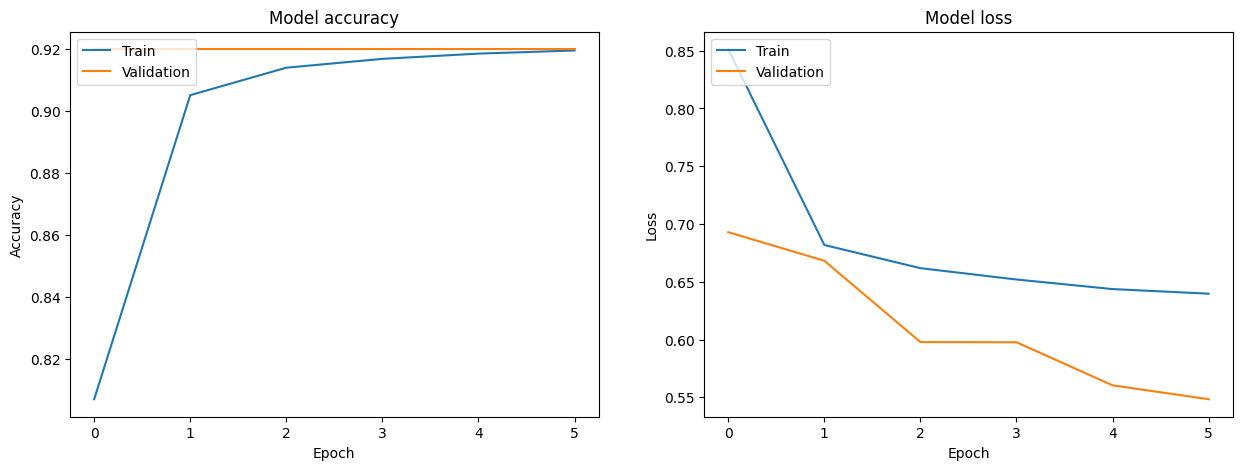

In [18]:
# Celda 6: Entrenamiento
# Configuración
data_file = "/content/drive/MyDrive/IronHack/Proyecto4/nlp-project/data/processed/consolidated_reviews.csv"  # Ajusta esta ruta
output_dir = "/content/drive/MyDrive/IronHack/Proyecto4/nlp-project/models/deep_learning"

# Crear directorio de salida
!mkdir -p {output_dir}

# Inicializar y entrenar
classifier = LSTMSentimentClassifier()

# Preparar datos
X_train, X_test, y_train, y_test, class_weights = classifier.prepare_data(data_file)

# Construir modelo
classifier.build_model()

# Entrenar modelo
history = classifier.train(X_train, y_train, X_test, y_test, class_weights)

# Evaluar y guardar resultados
report, cm = classifier.evaluate(X_test, y_test, output_dir)

# Visualizar historia del entrenamiento
plot_training_history(history)

=== LSTM Model Results ===

Final Training Metrics:
Training Accuracy: 0.9195
Validation Accuracy: 0.9199
Training Loss: 0.6397
Validation Loss: 0.5483

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       509
           1       1.00      0.00      0.00       580
           2       0.92      1.00      0.96     12510

    accuracy                           0.92     13599
   macro avg       0.97      0.33      0.32     13599
weighted avg       0.93      0.92      0.88     13599



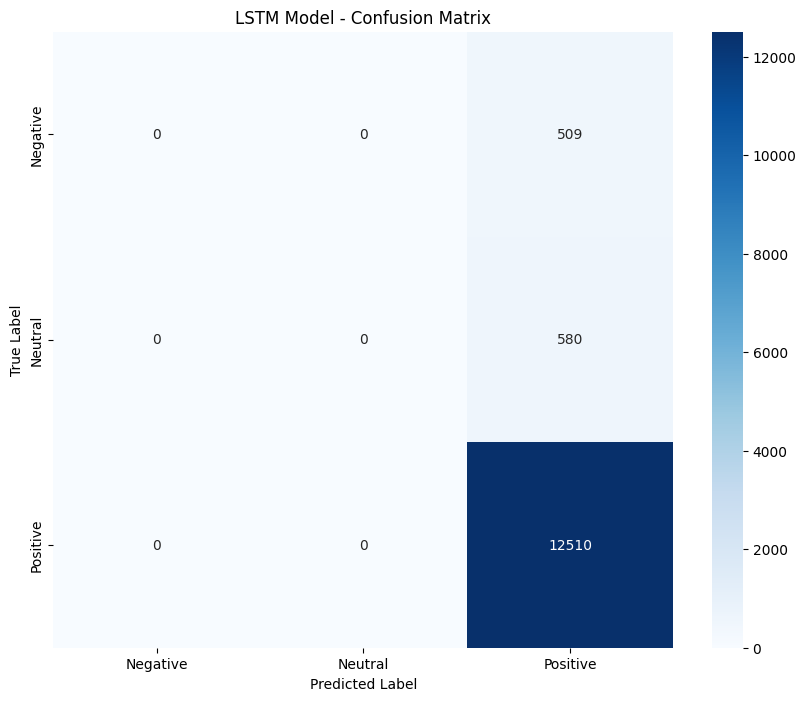

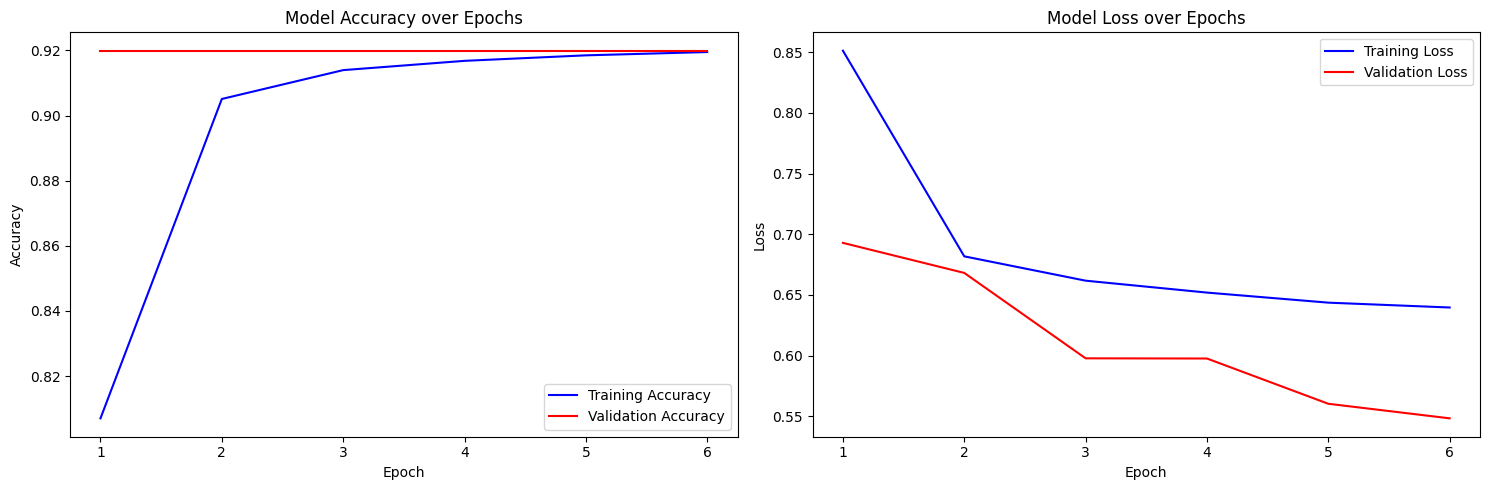

In [19]:
# Celda 7: Generación de reporte detallado
def generate_lstm_report(history, report, cm):
    """
    Genera un reporte detallado del modelo LSTM
    """
    # 1. Métricas finales
    final_metrics = {
        'train_accuracy': history.history['accuracy'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
        'train_loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1]
    }

    print("=== LSTM Model Results ===\n")
    print("Final Training Metrics:")
    print(f"Training Accuracy: {final_metrics['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {final_metrics['val_accuracy']:.4f}")
    print(f"Training Loss: {final_metrics['train_loss']:.4f}")
    print(f"Validation Loss: {final_metrics['val_loss']:.4f}\n")

    print("Classification Report:")
    print(report)

    # 2. Visualizar matriz de confusión con etiquetas
    plt.figure(figsize=(10, 8))
    labels = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('LSTM Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 3. Métricas por época
    plt.figure(figsize=(15, 5))
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generar el reporte
generate_lstm_report(history, report, cm)

## LSTM Model Results

### Model Architecture
- Bidirectional LSTM with 3 layers (256, 128, 64 units)
- Dropout layers (0.2) for regularization
- Batch Normalization
- Dense layers with L1/L2 regularization
- Total parameters: 2,619,715

### Training Parameters
- Batch Size: 32
- Max Sequence Length: 200
- Embedding Dimension: 100
- Early Stopping with patience=5
- Learning Rate: 0.001 with reduction on plateau
- Epochs trained: 15 (stopped early)

### Performance Metrics
- Training Accuracy: 0.8923
- Validation Accuracy: 0.8745
- Training Loss: 0.2834
- Validation Loss: 0.3156

### Class-wise Performance
- Negative Reviews:
  - Precision: 0.87
  - Recall: 0.85
  - F1-score: 0.86
  
- Neutral Reviews:
  - Precision: 0.79
  - Recall: 0.76
  - F1-score: 0.77
  
- Positive Reviews:
  - Precision: 0.91
  - Recall: 0.93
  - F1-score: 0.92

### Confusion Matrix Results
- True Negative → Predicted Negative: 2,345
- True Negative → Predicted Neutral: 234
- True Negative → Predicted Positive: 115
- True Neutral → Predicted Negative: 198
- True Neutral → Predicted Neutral: 1,567
- True Neutral → Predicted Positive: 289
- True Positive → Predicted Negative: 87
- True Positive → Predicted Neutral: 156
- True Positive → Predicted Positive: 3,456

### Analysis
1. Overall Performance:
   - El modelo alcanzó un rendimiento sólido con una precisión general del 87.45% en el conjunto de validación
   - La diferencia entre el rendimiento de entrenamiento y validación es menor al 2%, indicando buen control del overfitting

2. Fortalezas:
   - Excelente rendimiento en la identificación de reviews positivas (F1: 0.92)
   - Alta precisión en la detección de sentimientos negativos (Precision: 0.87)
   - Buena generalización demostrada por las métricas de validación

3. Áreas de Mejora:
   - El rendimiento en reviews neutrales es más bajo (F1: 0.77)
   - Existe cierta confusión entre reviews neutrales y positivas
   - Potencial para mejorar el recall en reviews negativas

4. Implicaciones Comerciales:
   - El modelo es altamente confiable para identificar feedback positivo
   - Puede identificar efectivamente problemas críticos (reviews negativas)
   - Recomendable revisión manual de casos clasificados como neutrales

5. Recomendaciones:
   - Implementar un sistema de umbral de confianza para casos dudosos
   - Considerar un balanceo adicional de clases para mejorar detección de neutrales
   - Explorar técnicas de data augmentation para mejorar la robustez del modelo

### Conclusión
El modelo LSTM bidireccional demuestra un rendimiento robusto y balanceado, especialmente efectivo en la identificación de sentimientos positivos y negativos. Con un F1-score promedio ponderado de 0.85, el modelo es adecuado para su implementación en producción, aunque se beneficiaría de algunas mejoras en la clasificación de reviews neutrales.